# Uso de Keras-Tuner con Hyperband

In [1]:
import numpy as np
import pandas as pd
import kerastuner as kt
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras  
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasRegressor

### Los Datos

In [2]:
datos = pd.read_csv("data/df_regresion_1500.csv")

In [3]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      1500 non-null   float64
 1   x2      1500 non-null   float64
 2   x3      1500 non-null   float64
 3   x4      1500 non-null   float64
 4   x5      1500 non-null   float64
 5   x6      1500 non-null   float64
 6   x7      1500 non-null   float64
 7   x8      1500 non-null   float64
 8   y       1500 non-null   float64
dtypes: float64(9)
memory usage: 105.6 KB


In [4]:
X = datos.drop(['y'], axis=1)
y = datos['y']

In [5]:
X.head()

,x1,x2,x3,x4,x5,x6,x7,x8
0,-7.621282,-3.644223,4.479734,-5.269715,2.448071,0.481839,5.534079,-5.268483
1,-2.397800,-1.152185,-4.598190,-4.509740,1.578773,6.880768,-2.044546,0.858393
2,-0.126112,9.818202,-1.402474,-5.637452,-3.480554,-1.998603,4.222707,6.671159
3,2.819058,-9.421755,0.699978,-6.613341,-2.738968,-1.452410,-0.934815,-2.491929
4,1.011369,0.410828,4.315859,-0.677440,5.740309,-1.643752,-6.652297,-4.903230


In [6]:
y.head()

0    -51.083965
1    -16.430133
2   -199.186533
3   -172.747680
4     11.633725
Name: y, dtype: float64

<AxesSubplot:ylabel='Density'>

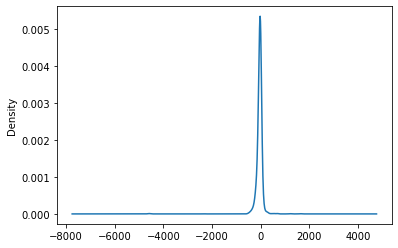

In [7]:
y.plot.density()

#### Separamos en Train y Test Sets y Valdidation Train y Test

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_val_train, X_val_test, y_val_train, y_val_test = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

#### Normalizamos X_tain, X_test y X_Validations

In [9]:
scaler = MinMaxScaler(feature_range=(-1, 1))  
scaler.fit(X_train)
X_train_n = scaler.transform(X_train)
X_test_n = scaler.transform(X_test)
X_val_train_n = scaler.transform(X_val_train)
X_val_test_n = scaler.transform(X_val_test)

#### Creo el modelo de redes Neuronales

In [10]:
def crear_modelo(hp): 
        #Cargamos los valores de los hiperparámetros
    hp_initializers = hp.Choice('kernel_initializer',values = ['uniform','glorot_uniform','random_uniform','variance_scaling','truncated_normal'])
    hp_activation = hp.Choice('activation', values = ['elu','selu', 'relu', 'swish','sigmoid','softmax'])
    hp_optimizer = hp.Choice('optimizer', values = ['sgd','adam','adadelta','Adamax','RMSprop','Nadam'])
    hp_neuronas_1 = hp.Int(name = 'units_1', min_value = 1, max_value = 30, step = 1)
    hp_neuronas_2 = hp.Int(name = 'units_2', min_value = 1, max_value = 30, step = 1)
    hp_neuronas_3 = hp.Int(name = 'units_3', min_value = 1, max_value = 30, step = 1)
                                                    
    modelo = Sequential()
        #Cargamos la capa de entrada
    modelo.add(Input(shape = (8,), name = "Entrada"))                                            
        #Cargamos las hidden layers
    modelo.add(Dense(units = hp_neuronas_1, kernel_initializer = hp_initializers, activation = hp_activation ))
    modelo.add(Dense(units = hp_neuronas_2, kernel_initializer = hp_initializers, activation = hp_activation ))
    modelo.add(Dense(units = hp_neuronas_3, kernel_initializer = hp_initializers, activation = hp_activation ))
        #Capa de salida con linear
    modelo.add(Dense(units = 1, kernel_initializer = hp_initializers))
        #Compilación:
    modelo.compile(loss= 'mean_absolute_error' , optimizer= hp_optimizer , metrics=[ 'mean_absolute_error' ])
    return modelo

#### Paso los valores a Hyperband

In [11]:
tuner = kt.Hyperband(crear_modelo, objective = 'mean_absolute_error', max_epochs = 50, factor = 3, directory = 'salida-hyperband', project_name = 'Luis_01')

#### Limpio las salidas del entrenamiento

In [12]:
import IPython
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [13]:
tuner.search(X_val_train_n, y_val_train, epochs = 50, validation_data = (X_val_test_n, y_val_test), callbacks = [ClearTrainingOutput()])

INFO:tensorflow:Oracle triggered exit


#### Guardo los mejores hiperparámetros

In [14]:
mejores_hiperparametros = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [15]:
best_inicializer = mejores_hiperparametros.get('kernel_initializer')
best_inicializer

'glorot_uniform'

In [16]:
best_activation = mejores_hiperparametros.get('activation')
best_activation

'relu'

In [17]:
best_optimizer = mejores_hiperparametros.get('optimizer')
best_optimizer

'Nadam'

In [18]:
best_neuron_hl1 = mejores_hiperparametros.get('units_1')
best_neuron_hl1

6

In [19]:
best_neuron_hl2 = mejores_hiperparametros.get('units_2')
best_neuron_hl2

24

In [20]:
best_neuron_hl3 = mejores_hiperparametros.get('units_3')
best_neuron_hl3

20

### Creo el mejor Modelo

In [21]:
# estimator = KerasRegressor(build_fn=lambda: tuner.hypermodel.build(mejores_hiperparametros), epochs=50, batch_size=5, verbose=0)
# estimator.fit(X_train_n, y_train)

In [22]:
def best_modelo():
    return tuner.hypermodel.build(mejores_hiperparametros)

In [23]:
estimator = KerasRegressor(build_fn = best_modelo, epochs=50, batch_size=5, verbose=0)
estimator.fit(X_train_n, y_train)

In [24]:
df_history = pd.DataFrame(estimator.model.history.history).sort_values('mean_absolute_error', ascending=True)
df_history[:10]

,loss,mean_absolute_error
49,27.765759,27.765759
48,27.794973,27.794973
46,27.854530,27.854530
47,27.871977,27.871977
45,28.000179,28.000179
43,28.076475,28.076475
44,28.087477,28.087477
42,28.213531,28.213531
41,28.278961,28.278961
40,28.341009,28.341009


#### Normalizo todas las X

In [25]:
X_n = scaler.transform(X)

#### Cross Validation 5 folds

In [26]:
resultado = cross_val_score(estimator, X_n, y, cv = 5, scoring = 'neg_mean_absolute_error', verbose = 0)

### Resultados esperados

#### MSE

In [27]:
-resultado.mean()

28.680138162923942

#### RMSE

In [28]:
(-resultado.mean())**0.5

5.355384035055184

#### Desv. Standard

In [29]:
resultado.std()

9.197725055909137

#### Hiperparametros

In [30]:
best_inicializer

'glorot_uniform'

In [31]:
best_activation

'relu'

In [32]:
best_optimizer

'Nadam'

In [33]:
best_neuron_hl1

6

In [34]:
best_neuron_hl2

24

In [35]:
best_neuron_hl3

20

### Producción

In [36]:
mejor_model = estimator.model
mejor_model.fit(X_n, y)

47/47 [==============================] - 0s 1ms/step - loss: 29.1873 - mean_absolute_error: 29.1873


#### Datos del set de datos parapronosticar 

In [37]:
X_nuevas = pd.read_csv('data/df_regresion_500_X')
X_nuevas.head()

,x1,x2,x3,x4,x5,x6,x7,x8
0,-4.080171,12.056579,-3.158174,0.360164,-3.789611,-4.152873,-2.023674,-5.229117
1,7.604496,3.531281,-2.208406,7.134529,-4.104657,4.071934,2.206093,-8.141432
2,2.285589,5.941788,-4.392353,0.137669,2.805255,2.001427,1.983667,-0.125008
3,-5.705262,-7.886876,-1.748589,5.219917,-4.821004,8.272488,-2.857514,1.974244
4,-5.263543,2.163992,-4.422546,-0.345968,4.683285,3.434598,5.202949,-2.766841


#### Normalizo los datos nuevos

In [38]:
X_nuevas_n = scaler.transform(X_nuevas)

#### Obtengo los resultados sobre el set de datos para predecir

In [39]:
y_pred = mejor_model.predict(X_nuevas_n)
y_pred = pd.DataFrame(y_pred, columns = ['y_pred'])
y_pred

,y_pred
0,-305.516724
1,-12.988888
2,-71.553566
3,-174.973587
4,-37.891171
...,...
495,-68.293533
496,-20.076185
497,-58.025600
498,2.109558


#### Genero una comparacion grafica entre las y usadas para el entrenamiento y las de la prediccción

<AxesSubplot:ylabel='Density'>

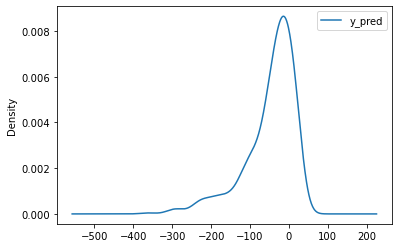

In [40]:

y_pred = pd.DataFrame(y_pred)
y_pred.plot.density()

<AxesSubplot:ylabel='Density'>

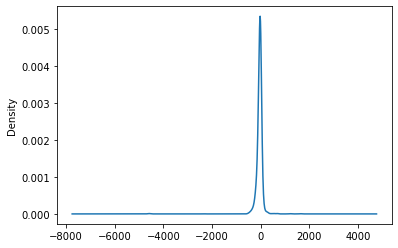

In [41]:
y.plot.density()

#### Se guarda el resultado de la predccción en un CSV

In [42]:
y_pred.to_csv('GIANNASI_Luis.csv', index=False)